# **old model**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

In [3]:
# Identify empty cells

data.isnull().sum()
data_cleaned = data.dropna()

print(f"Rows before cleaning: {data.shape[0]}")
print(f"Rows after cleaning: {data_cleaned.shape[0]}")

# Identify categorical columns
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor


# Print unique value counts for each categorical column
for col in categorical_columns:
  unique_count = data_cleaned[col].nunique()
  print(f"Unique values in {col}: {unique_count}")


X = data_cleaned.drop(columns=["Critic_Score", 'Name'])  # Drop 'Critic_Score' and 'Name' columns
y = data_cleaned["Critic_Score"]

# Label encode 'Developer' column
label_encoder = LabelEncoder()
X['Developer_encoded'] = label_encoder.fit_transform(X['Developer'])

# Drop the original 'Developer' column
X = X.drop(columns=['Developer'])

# One-hot encode the other categorical columns: 'Platform', 'Genre', 'Publisher', 'User_Score', 'Rating'
# We will use pd.get_dummies for simplicity
X = pd.get_dummies(X, columns=['Platform', 'Genre', 'Publisher', 'User_Score', 'Rating'], drop_first=True)


Rows before cleaning: 16719
Rows after cleaning: 6825
Categorical columns: ['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer', 'Rating']
Unique values in Name: 4377
Unique values in Platform: 17
Unique values in Genre: 12
Unique values in Publisher: 262
Unique values in User_Score: 89
Unique values in Developer: 1289
Unique values in Rating: 7


In [4]:
# Split the dataset into training and testing sets
X_old_train, X_old_test, y_old_train, y_old_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the XGBoost model
model = XGBRegressor(random_state=42)
model.fit(X_old_train, y_old_train)

# Make predictions
y_old_pred = model.predict(X_old_test)

# **Error Analysis Conclusions & work plan**

From the analysis shown in the previous part:

**Scatterplot Analysis (Actual vs. Predicted):**

The predicted values mostly follow the trend of the actual values, but there is visible variance, especially for extreme values tends to smaller Critic_Score value. This suggests that the model struggles to generalize accurately at the extremes, possibly due to insufficient data points in these regions during training.


**Residuals Histogram:**

The residuals are approximately centered around zero, indicating that the model predictions are unbiased overall.
However, there is a slightly higher number of underestimations (733) compared to overestimations (632). This discrepancy might suggest a bias in the training process or an imbalance in the dataset.


**Feature Importance (from XGBoost):**

Features like "Year_of_Release" and "NA_Sales" dominate the model's predictions. This dominance might mean that the model overly relies on these features, potentially ignoring other valuable input variables. This could lead to suboptimal performance, especially if these features are not strongly predictive for specific subsets of data.


**Causes of Errors:**
Bias in Training Data: The training data might not represent extreme values or rare cases sufficiently.

**Feature Imbalance:** The dominance of a few features might skew the model’s learning process, leading to overfitting on specific patterns related to those features.

**Steps to Address Issues:**

**Feature Engineering:**

Investigate and balance feature contributions by creating new features or applying dimensionality reduction techniques like PCA to de-emphasize less relevant features.

**Hyperparameter Tuning:**

Experiment with hyperparameters (e.g., tree depth, learning rate) to improve model flexibility and performance.


**Handling Missing Data or Outliers Effectively:**

Identify and handle missing data points using imputation methods such as mean, median, or predictive imputation.
Detect and handle outliers through techniques like winsorization, clipping, or by using robust algorithms that are less sensitive to outliers.


# **Improving Model Performance**

**Steps to Address Weaknesses:**

1. Improved Handling of Missing Data:

  Instead of dropping rows, use imputation methods for missing data, such as:
  Numerical columns: Replace missing values with the mean, median, or use predictive imputation techniques.
  Categorical columns: Replace missing values with the mode or a placeholder category.

2. Dimensionality Reduction for High-Cardinality Categorical Variables:

  For categorical variables like Publisher, consider grouping rare categories into an "Other" category or using techniques like target encoding.


3. Feature Scaling:

  Although not always necessary for tree-based models, scaling numerical features could improve convergence and make the dataset more interpretable during preprocessing.

4. Cross-Validation:

  Use K-fold cross-validation to ensure the model is evaluated on multiple subsets of the data, providing a more robust assessment of its performance.

5. Hyperparameter Tuning:

  Tune hyperparameters like learning rate, max depth, and number of estimators using grid search or Bayesian optimization to prevent overfitting.



# **1. Feature Engineering**

In [5]:
data = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

In [6]:
# Create new features
data['Year_Interval'] = 2025 - data['Year_of_Release']  # Feature: Years since release

# Transform numerical features
data['User_Score'] = data['User_Score'].apply(lambda x: float(x) if x != 'tbd' else None)

# Log-transform skewed numerical features to reduce impact of outliers
import numpy as np
data['Log_Global_Sales'] = np.log1p(data['Global_Sales'])


# **2. Handling Missing Data or Outliers**


In [7]:
from sklearn.impute import SimpleImputer

# Identify numerical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Handle missing values in numerical features
num_imputer = SimpleImputer(strategy='mean')
data[num_cols] = num_imputer.fit_transform(data[num_cols])

# Handle missing values in categorical features
cat_imputer = SimpleImputer(strategy='most_frequent')
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Cap outliers in numerical features
for col in ['Global_Sales', 'Critic_Score']:
    upper_limit = data[col].quantile(0.95)
    lower_limit = data[col].quantile(0.05)
    data[col] = np.clip(data[col], lower_limit, upper_limit)


# **3. Balancing data**

In [8]:
from sklearn.utils import resample

# Define the target and features
y = data["Critic_Score"]
X = data.drop(columns=["Critic_Score", "Name"])

# Check for imbalance in target variable
print(y.value_counts())

# Combine features and target into a single DataFrame
data = pd.concat([X, y], axis=1)

threshold = 60

# Split data into groups based on the target variable's ranges
minority = data[data['Critic_Score'] < threshold]
majority = data[data['Critic_Score'] >= threshold]

# Oversample the minority group
minority_oversampled = resample(minority,
                                replace=True,
                                n_samples=len(majority),
                                random_state=42)

# Combine oversampled minority with the majority
balanced_data = pd.concat([majority, minority_oversampled])

# Separate features and target again
X_balanced = balanced_data.drop(columns=['Critic_Score'])
y_balanced = balanced_data['Critic_Score']

Critic_Score
68.967679    8582
85.000000     960
50.000000     881
70.000000     256
71.000000     254
75.000000     245
78.000000     240
73.000000     238
80.000000     237
76.000000     235
72.000000     226
74.000000     226
77.000000     225
68.000000     219
79.000000     218
81.000000     218
69.000000     215
82.000000     208
83.000000     206
66.000000     203
65.000000     192
84.000000     183
67.000000     182
63.000000     178
62.000000     170
64.000000     169
61.000000     165
59.000000     157
60.000000     156
58.000000     151
57.000000     132
56.000000     113
55.000000     110
54.000000     103
53.000000     103
51.000000      90
52.000000      73
Name: count, dtype: int64


**split the data**

In [9]:
from sklearn.model_selection import train_test_split
# Convert categorical columns to 'category' dtype
categorical_columns = ["Platform", "Genre", "Publisher", "Developer", "Rating"]
for col in categorical_columns:
    X_balanced[col] = X_balanced[col].astype("category")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# **4. Hyperparameter Tuning**

In [10]:
import xgboost as xgb
from itertools import product

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15, 0.17],
    'max_depth': [3, 7, 8, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize an empty list to store results
best_results = []

# Iterate over all parameter combinations
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    # Add the default XGBoost parameters
    param_dict.update({
        'objective': 'reg:squarederror',  # Regression task
        'eval_metric': 'rmse'  # Root Mean Squared Error as evaluation metric
    })

    # Perform cross-validation using xgboost.cv
    results = xgb.cv(params=param_dict, dtrain=dtrain, nfold=3,
                     metrics='rmse', as_pandas=True, seed=42)

    # Append the results to the list
    best_results.append((results['test-rmse-mean'].min(), param_dict))

# Find the best parameters based on the minimum RMSE
best_score, best_params = min(best_results, key=lambda x: x[0])

print("Best Parameters:", best_params)


Best Parameters: {'learning_rate': 0.17, 'max_depth': 9, 'subsample': 1.0, 'colsample_bytree': 0.9, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}


# **New Model**

In [11]:
from xgboost import XGBRegressor

best_params.update({
    'random_state': 42,
    'enable_categorical': True  # Enable categorical feature support
})

# Train the XGBoost model
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Train the XGBoost model with categorical support enabled
model = XGBRegressor(random_state=42, enable_categorical=True)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)



# **Analyzing the Improved Model**

In [12]:
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

print("R^2 Score:","{:,.3f}".format(r2_score(y_test, y_pred)))
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred) * 100))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))


R^2 Score: 0.879
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 2.229
Mean Absolute Error (Σ|y - pred|/n): 2
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 4


**Feature Importance**

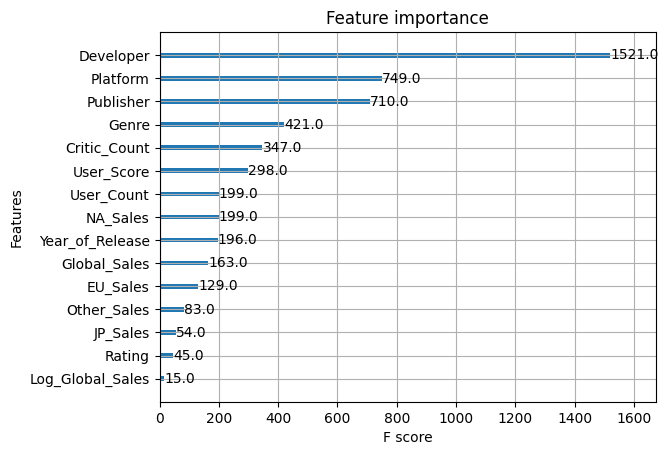

In [13]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plot_importance(model, importance_type='weight')
plt.show()


We can see that Developer is the most important feature, with the highest frequency of splits (1521). This suggests it significantly impacts the predictions.
Platform and Publisher follow as the next most important features, with values of 749 and 710, respectively.

Features like Log_Global_Sales, Rating, and JP_Sales have much lower importance scores, indicating they play a minor role in the model's decision-making.

**Insights:**
The model relies heavily on categorical features (e.g., Developer, Platform) for splitting, which could align with domain knowledge about how these attributes influence the target variable.
Continuous variables like Global_Sales and Critic_Count also contribute meaningfully but less so than categorical features.

PermutationExplainer explainer: 501it [03:35,  2.26it/s]


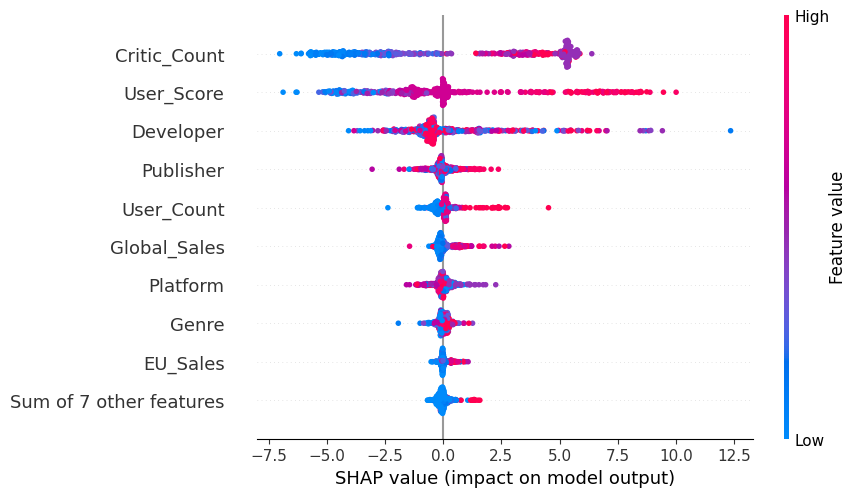

In [14]:
import shap
from sklearn.preprocessing import OrdinalEncoder

X_test_encoded = X_test.copy()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Identify categorical features
categorical_cols = X_test_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Fit and transform the encoder on categorical features
X_test_encoded[categorical_cols] = encoder.fit_transform(X_test_encoded[categorical_cols])

# Create the SHAP explainer
explainer = shap.Explainer(model.predict, X_test_encoded)

# Calculate SHAP values for a sample of the training data
shap_values = explainer(X_test_encoded.sample(500))

# Generate the beeswarm plot
shap.plots.beeswarm(shap_values)

Critic_Score and User_Score are the most influential features in the model. Most SHAP values fall within the range of -2.5 to 2.5. However, some features exhibit SHAP values ranging from -7 to 10, indicating that a low feature value can significantly lower the prediction, while a high feature value can substantially increase it.

For Critic_Count, higher values (red) tend to have positive SHAP values, meaning higher critic counts increase the model's predictions.
For User_Score, higher scores (red) also positively impact predictions, but the effect can sometimes be neutral or slightly negative, as seen from overlapping dots.
Developer and Publisher show high variation, indicating their influence on the model depends on the data point.
Features like Global_Sales and EU_Sales have less spread, suggesting they contribute less to the overall model predictions.



**The Difference between results of XGBoost Feature Importance and SHAP:**

Developer is frequently used for splits (high frequency in the XGBoost plot), but its overall contribution to prediction changes might be smaller.
User_Score might have fewer splits but creates larger prediction shifts, making it more important according to SHAP.

Model Behavior:
Some features (e.g., Developer) may be used as early splits to segregate data, even if they have a minor impact.
Other features (e.g., User_Score) might contribute to larger prediction changes but are used less frequently.

**Explain Model Performance**

The improved model demonstrates significantly better performance compared to the baseline model across all the evaluated metrics:

1. R-squared (R^2): The R^2 value increased substantially from 0.600 to 0.879. This indicates that the improved model explains a much larger proportion of the variance in the target variable (Critic_Score), meaning it's a much better fit to the data.

2. Mean Absolute Percentage Error (MAPE): The MAPE decreased drastically from 11.576% to 2.229%. This shows a significant reduction in the average percentage difference between predicted and actual values, suggesting much higher prediction accuracy.

3. Mean Absolute Error (MAE): The MAE decreased from 7 to 2, indicating a substantial reduction in the average absolute difference between predicted and actual values. This means the improved model's predictions are, on average, much closer to the true values.

4. Root Mean Squared Error (RMSE): The RMSE decreased from 9 to 4, which signifies a notable reduction in the average difference between predicted and actual values, emphasizing improved accuracy. Lower RMSE values suggest better model performance.



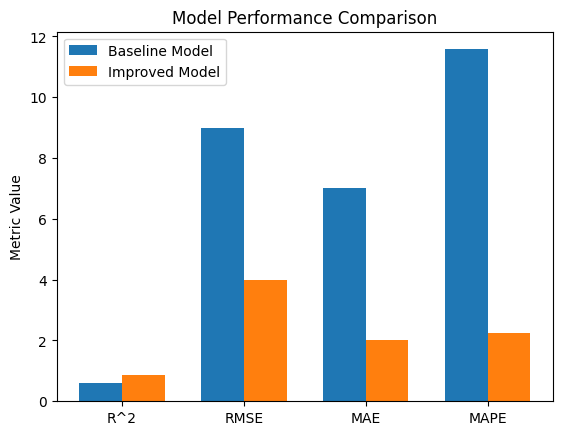

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Baseline model metrics
baseline_metrics = {
    'R^2': 0.600,
    'RMSE': 9,
    'MAE': 7,
    'MAPE': 11.576
}

# Improved model metrics
improved_metrics = {
    'R^2': 0.879,
    'RMSE': 4,
    'MAE': 2,
    'MAPE': 2.229,
}

# Metric names for the x-axis
metrics = list(baseline_metrics.keys())

# Metric values for the baseline and improved models
baseline_values = list(baseline_metrics.values())
improved_values = list(improved_metrics.values())

# Set the width of the bars
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots()

# Bars for the baseline model
baseline_bars = ax.bar(np.arange(len(metrics)), baseline_values, bar_width, label='Baseline Model')

# Bars for the improved model
improved_bars = ax.bar(np.arange(len(metrics)) + bar_width, improved_values, bar_width, label='Improved Model')

# Set the x-axis labels and tick positions
ax.set_xticks(np.arange(len(metrics)) + bar_width / 2)
ax.set_xticklabels(metrics)

# Set the y-axis label
ax.set_ylabel('Metric Value')

# Set the title of the chart
ax.set_title('Model Performance Comparison')

# Add a legend
ax.legend()

# Display the chart
plt.show()

**Reasons for Improvement:**

These substantial performance gains are likely attributed to the following factors incorporated in the improved model:

1. Feature Engineering: Creating new features like Year_Interval and log-transforming skewed features like Global_Sales likely provided more predictive power to the model.
2. Handling Missing Data: Imputing missing values instead of dropping them preserved valuable data points and prevented information loss, which might have significantly improved model training and prediction accuracy.
3. Balancing data: Addressing the class imbalance by oversampling the minority class allowed the model to learn more effectively from all classes, leading to better overall predictions.
4. Hyperparameter Tuning: By using cross-validation and optimizing hyperparameters like learning_rate, max_depth, and subsample, the model was fine-tuned for greater accuracy and generalization capabilities.

ploting actual/predicted old and new

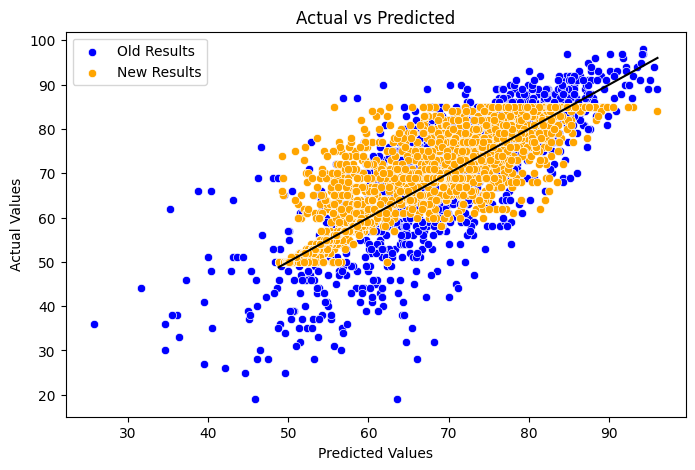

In [16]:
# Create a scatterplot for actual vs predicted values
fig, ax = plt.subplots(figsize=(8, 5))

# Plot old results in blue
sns.scatterplot(x=y_old_pred, y=y_old_test, ax=ax, color='blue', label='Old Results')

# Plot new results in orange
sns.scatterplot(x=y_pred, y=y_test, ax=ax, color='orange', label='New Results')

sns.lineplot(x=y_pred, y=y_pred, ax=ax, color='black')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Actual vs Predicted')
ax.legend()

plt.show()

This plot visually demonstrates that the new model outperforms the old model, with better alignment to actual values, reduced prediction errors, and more consistent behavior.

<Axes: >

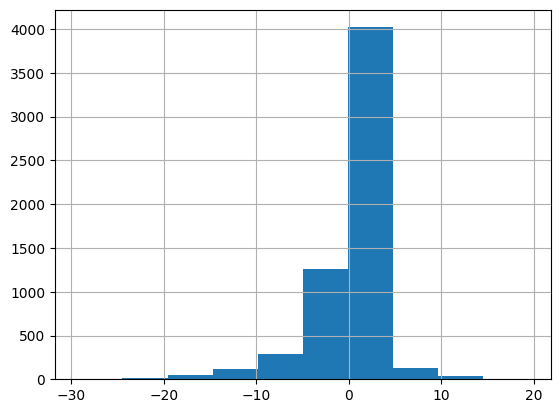

In [17]:
# Calculate prediction residuals
residuals = y_pred - y_test

overestimations = np.sum(residuals > 0)
underestimations = np.sum(residuals < 0)

residuals.hist()

The majority of errors are clustered around zero, indicating that the model's predictions are generally accurate.
The old model's errors span a wider range, including more extreme overestimations and underestimations.

(Here we have more overestimations & underestimations because we didn't drop the rows with null -> about more 10,000 lines)

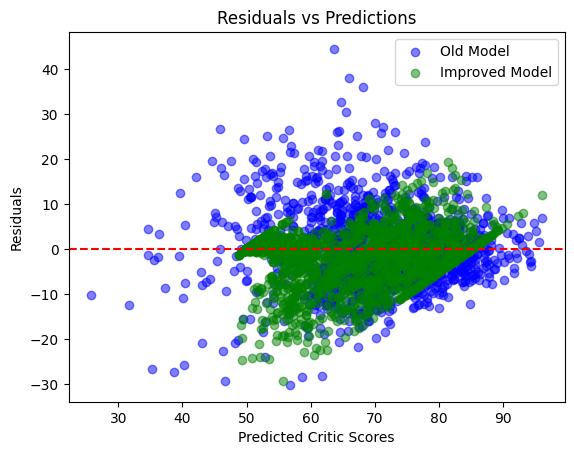

In [18]:
old_residuals = y_old_pred - y_old_test

plt.scatter(y_old_pred, old_residuals, alpha=0.5, label="Old Model", color='blue')
plt.scatter(y_pred, residuals, alpha=0.5, label="Improved Model", color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Critic Scores")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.legend()
plt.show()


The improved XGBoost model performs significantly better than the old model. Its residuals are tightly clustered around zero, indicating more accurate predictions, fewer outliers, and reduced systematic errors. In contrast, the old model has a wider spread of residuals, showing less consistent and less accurate predictions.

# **Drawing Conclusions About the Data & Creative Applications**

**Feature Significance:**
From the XGBoost feature importance plot, Developer, Platform, and Publisher are most frequently used in tree splits.
From the SHAP analysis, User_Score and Critic_Count have the highest overall impact on predictions.
Conclusion: This suggests that both categorical features (e.g., Developer) and numeric scores (e.g., User_Score) are critical to determining outcomes in the model.

**Biases or Trends:**
Correlations:
High User_Score and Critic_Count are positively correlated with the target variable.
Certain Developers or Publishers might dominate the results, indicating a potential bias in the dataset (popular publishers likely contribute more to sales).

Trends:
Features like Year_of_Release might reveal temporal trends (newer games could perform differently).
Regional sales (e.g., EU_Sales, JP_Sales) might show differences in feature importance across different markets.

**Data Insights:**
Surprises:
Critic_Count being highly significant might indicate that public reception (critic reviews) heavily influences success.
Genre or Platform may not be as influential as initially assumed if their SHAP values are low.

Insights:
Combining User_Score with other features (e.g., Developer) could create powerful interactions driving predictions.
Sales data might highlight specific underperforming regions, suggesting areas for business growth.


**Our model reveals that User Scores and Critic Reviews are critical drivers of success, highlighting the importance of public perception. Interestingly, while developers play a significant role in tree-based decision-making, they have less impact on the overall prediction than user-driven metrics. Regional differences in sales suggest targeted marketing strategies could boost performance in underperforming markets.**

**Propose potential applications for the dataset or findings**

a. Targeted Marketing Campaigns

* Use User_Score and Critic_Count to identify games likely to succeed in specific regions. By analyzing the User_Score and Critic_Count for games in different regions, you can identify which games are most likely to be popular in those regions. This information can be used to target your marketing campaigns more effectively. For example, you could focus your marketing efforts on promoting games that are expected to be popular in a particular region.

* For developers or publishers with lower predicted success, offer marketing strategies or partnerships to improve reach. Developers or publishers can use the model's predictions to identify games that are at risk of underperforming. Once these games have been identified, marketing strategies or partnerships can be developed to help improve their reach and increase their chances of success. For example, a game predicted to have low success could be marketed towards communities whose interests overlap with the game's themes. These communities may then help expand the game's reach organically, boosting its potential for success.

b. Predictive Tools
* Build a game success prediction tool for developers, allowing them to input pre-launch metrics (expected User Score, Developer name) to estimate sales performance. By taking pre-launch metrics as input, developers and publishers can estimate potential sales performance before the game's actual release. This provides valuable insights into the game's prospective success or areas needing improvement, before launching the game to market.

* Provide dashboards for publishers to monitor regional trends and adjust strategies dynamically. Real-time data tracking dashboards would allow developers and publishers to monitor regional trends and patterns. This will enable them to dynamically adjust strategies to changing conditions.

c. Game Development Guidance
Share insights with game developers to emphasize the importance of critic engagement and improving user feedback loops for better outcomes. Sharing insights gleaned from the model with game developers can help them better understand the factors that influence the target variable. For example, if the model shows that User_Score is a key driver of success, then developers may wish to focus their efforts on improving user feedback loops to address concerns of target audiences.

d. Market-Specific Models
rain separate models for different regions like EU, JP to fine-tune strategies for individual markets. By training individual models tailored to specific markets, the regional nuances that impact sales can be factored in. This allows game developers to refine their marketing and promotional efforts according to the particular tastes and preferences within specific regions or markets, enhancing the game's chances of success.